<a href="https://colab.research.google.com/github/Pavanishreebs/GuardianAI/blob/main/anomalypython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install pandas numpy scikit-learn matplotlib seaborn pyod xgboost lightgbm tensorflow

# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Initialize random seed for reproducibility
np.random.seed(42)
random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.4-py3-none-any.whl size=200479 sha256=0d8e75c4dd1723c8c6267bf658c973cb9ec14707fedc720a144b1c002b101c3e
  Stored in directory: /root/.cache/pip/wheels/cb/54/28/d02f62720600bc815c41219efedd0cb86889737fb5ea3c8f9a
Successfully built pyod


In [ ]:
def generate_user_behavior_data(num_users=100, num_days=90):
    """Generate synthetic user behavior data"""

    # User profiles
    departments = ['Engineering', 'Marketing', 'Finance', 'HR', 'Sales']
    roles = ['Employee', 'Manager', 'Admin', 'Executive']

    # Generate user base
    users = [{
        'user_id': f'user_{i}',
        'department': random.choice(departments),
        'role': random.choice(roles),
        'join_date': datetime.now() - timedelta(days=random.randint(100, 1000))
    } for i in range(num_users)]

    # Generate behavior data
    data = []
    current_date = datetime.now()

    for day in range(num_days):
        date = current_date - timedelta(days=num_days - day)
        for user in users:
            # Base behavior patterns
            is_weekday = date.weekday() < 5
            is_manager = user['role'] in ['Manager', 'Admin', 'Executive']
            department = user['department']

            # Normal behavior metrics
            login_attempts = max(1, int(np.random.normal(2, 1)))
            work_hours = max(4, min(12, np.random.normal(8, 2)))

            # File access patterns
            if department == 'Engineering':
                file_access = max(10, int(np.random.normal(30, 10)))
                code_editor_time = work_hours * 0.6
            elif department == 'Marketing':
                file_access = max(5, int(np.random.normal(20, 8)))
                code_editor_time = work_hours * 0.1
            else:
                file_access = max(5, int(np.random.normal(15, 5)))
                code_editor_time = work_hours * 0.05

            # AI model usage
            if is_manager:
                ai_usage = random.choice([0, 0, 0, 1])  # Rare usage
            else:
                ai_usage = random.choice([0, 0, 0, 0, 0, 1])  # Very rare

            # After hours access
            after_hours_access = 1 if random.random() < 0.1 else 0

            # Generate some anomalies (5% of data)
            is_anomaly = 0
            if random.random() < 0.05:
                is_anomaly = 1
                # Anomaly patterns
                login_attempts *= random.randint(2, 5)
                file_access *= random.randint(3, 10)
                ai_usage = random.randint(1, 5)
                after_hours_access = random.randint(1, 3)
                if random.random() < 0.3:
                    code_editor_time = work_hours * random.uniform(0.8, 1.2)

            data.append({
                'date': date.date(),
                'user_id': user['user_id'],
                'department': user['department'],
                'role': user['role'],
                'login_attempts': login_attempts,
                'file_access_count': file_access,
                'code_editor_hours': code_editor_time,
                'ai_model_usage_count': ai_usage,
                'after_hours_access': after_hours_access,
                'is_weekday': int(is_weekday),
                'is_anomaly': is_anomaly
            })

    return pd.DataFrame(data)

# Generate and preview data
behavior_df = generate_user_behavior_data(num_users=50, num_days=60)
print(f"Generated {len(behavior_df)} records")
behavior_df.head()

Generated 3000 records


,date,user_id,department,role,login_attempts,file_access_count,code_editor_hours,ai_model_usage_count,after_hours_access,is_weekday,is_anomaly
0,2025-02-04,user_0,Engineering,Employee,2,36,4.634083,1,0,1,0
1,2025-02-04,user_1,Finance,Manager,3,13,0.376585,0,0,1,0
2,2025-02-04,user_2,Marketing,Employee,3,16,0.953487,0,0,1,0
3,2025-02-04,user_3,Sales,Employee,2,12,0.353658,0,0,1,0
4,2025-02-04,user_4,HR,Employee,2,6,0.208672,0,0,1,0


In [ ]:
def create_features(df):
    """Create additional features for anomaly detection"""

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Create temporal features
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day

    # Create user behavior aggregates
    user_stats = df.groupby('user_id').agg({
        'login_attempts': ['mean', 'std'],
        'file_access_count': ['mean', 'std'],
        'code_editor_hours': ['mean', 'std'],
        'ai_model_usage_count': ['mean', 'std']
    })
    user_stats.columns = ['_'.join(col).strip() for col in user_stats.columns.values]
    user_stats = user_stats.reset_index()

    # Merge with original data
    df = df.merge(user_stats, on='user_id', how='left')

    # Create z-score features
    df['login_attempts_z'] = (df['login_attempts'] - df['login_attempts_mean']) / df['login_attempts_std'].replace(0, 1)
    df['file_access_z'] = (df['file_access_count'] - df['file_access_count_mean']) / df['file_access_count_std'].replace(0, 1)
    df['editor_hours_z'] = (df['code_editor_hours'] - df['code_editor_hours_mean']) / df['code_editor_hours_std'].replace(0, 1)
    df['ai_usage_z'] = (df['ai_model_usage_count'] - df['ai_model_usage_count_mean']) / df['ai_model_usage_count_std'].replace(0, 1)

    # Create anomaly score (simple version)
    df['simple_anomaly_score'] = (
        np.abs(df['login_attempts_z']) +
        np.abs(df['file_access_z']) +
        np.abs(df['editor_hours_z']) +
        np.abs(df['ai_usage_z'])
    )

    # Fill any NaN values (from std=0)
    df = df.fillna(0)

    return df

# Create features
behavior_df = create_features(behavior_df)

# Select final features for modeling
features = [
    'login_attempts', 'file_access_count', 'code_editor_hours',
    'ai_model_usage_count', 'after_hours_access', 'is_weekday',
    'login_attempts_z', 'file_access_z', 'editor_hours_z', 'ai_usage_z',
    'day_of_week', 'day_of_month', 'simple_anomaly_score'
]

# Separate features and target
X = behavior_df[features]
y = behavior_df['is_anomaly']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (temporal split - older data for training)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, shuffle=False, random_state=42
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Anomaly rate in train: {y_train.mean():.2%}, test: {y_test.mean():.2%}")

Training set: (2100, 13), Test set: (900, 13)
Anomaly rate in train: 4.62%, test: 5.22%


In [ ]:
# Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=0.05,  # Expected anomaly rate
    random_state=42,
    verbose=1
)

# Fit and predict
iso_forest.fit(X_train)
iso_scores = -iso_forest.decision_function(X_test)  # Higher = more anomalous

# Convert to binary predictions (using top 5% as anomalies)
iso_preds = np.where(iso_scores > np.percentile(iso_scores, 95), 1, 0)

# Evaluate
print("Isolation Forest Results:")
print(classification_report(y_test, iso_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, iso_preds))

Isolation Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       853
           1       1.00      0.96      0.98        47

    accuracy                           1.00       900
   macro avg       1.00      0.98      0.99       900
weighted avg       1.00      1.00      1.00       900

Confusion Matrix:
[[853   0]
 [  2  45]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


In [ ]:
# One-Class SVM model
ocs_vm = OneClassSVM(
    kernel='rbf',
    gamma='scale',
    nu=0.05  # Expected anomaly rate
)

# Fit and predict
ocs_vm.fit(X_train)
svm_scores = -ocs_vm.decision_function(X_test)  # Higher = more anomalous

# Convert to binary predictions (using top 5% as anomalies)
svm_preds = np.where(svm_scores > np.percentile(svm_scores, 95), 1, 0)

# Evaluate
print("\nOne-Class SVM Results:")
print(classification_report(y_test, svm_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, svm_preds))


One-Class SVM Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       853
           1       0.82      0.79      0.80        47

    accuracy                           0.98       900
   macro avg       0.91      0.89      0.90       900
weighted avg       0.98      0.98      0.98       900

Confusion Matrix:
[[845   8]
 [ 10  37]]


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.1465 - val_loss: 1.0413
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9996 - val_loss: 0.9767
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9224 - val_loss: 0.9024
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8347 - val_loss: 0.8118
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7455 - val_loss: 0.7239
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6643 - val_loss: 0.6521
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5595 - val_loss: 0.5900
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5415 - val_loss: 0.5372
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4980 - val_loss: 0.4972
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4629 - val_loss: 0.4617
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4447 - val_loss: 0.4278
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4

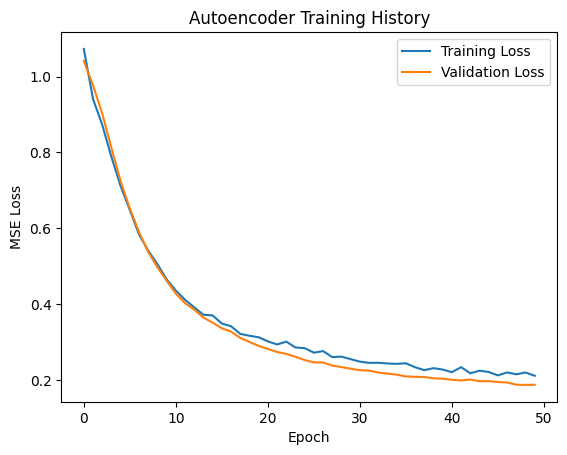

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Autoencoder Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       853
           1       0.82      0.79      0.80        47

    accuracy                           0.98       900
   macro avg       0.91      0.89      0.90       900
weighted avg       0.98      0.98      0.98       900

Confusion Matrix:
[[845   8]
 [ 10  37]]


In [ ]:
# Autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 7  # Size of encoded representations

autoencoder = Sequential([
    Dense(encoding_dim * 2, activation='relu', input_shape=(input_dim,)),
    Dropout(0.1),
    Dense(encoding_dim, activation='relu'),
    Dense(encoding_dim * 2, activation='relu'),
    Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, X_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Calculate reconstruction error
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
ae_scores = mse

# Convert to binary predictions (using top 5% as anomalies)
ae_preds = np.where(ae_scores > np.percentile(ae_scores, 95), 1, 0)

# Evaluate
print("\nAutoencoder Results:")
print(classification_report(y_test, ae_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, ae_preds))

In [ ]:
# Create ensemble predictions
ensemble_scores = (
    0.4 * iso_scores +
    0.3 * svm_scores +
    0.3 * ae_scores
)

# Scale ensemble scores to [0, 1] range
ensemble_scores = (ensemble_scores - ensemble_scores.min()) / (ensemble_scores.max() - ensemble_scores.min())

# Convert to binary predictions (using top 5% as anomalies)
ensemble_preds = np.where(ensemble_scores > np.percentile(ensemble_scores, 95), 1, 0)

# Evaluate
print("\nEnsemble Results:")
print(classification_report(y_test, ensemble_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, ensemble_preds))


Ensemble Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       853
           1       0.89      0.85      0.87        47

    accuracy                           0.99       900
   macro avg       0.94      0.92      0.93       900
weighted avg       0.99      0.99      0.99       900

Confusion Matrix:
[[848   5]
 [  7  40]]


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Generate synthetic data
def generate_user_behavior_data(num_users=100, num_days=90):
    departments = ['Engineering', 'Marketing', 'Finance', 'HR', 'Sales']
    roles = ['Employee', 'Manager', 'Admin', 'Executive']

    users = [{
        'user_id': f'user_{i}',
        'department': random.choice(departments),
        'role': random.choice(roles),
        'join_date': datetime.now() - timedelta(days=random.randint(100, 1000))
    } for i in range(num_users)]

    data = []
    current_date = datetime.now()

    for day in range(num_days):
        date = current_date - timedelta(days=num_days - day)
        for user in users:
            is_weekday = date.weekday() < 5
            is_manager = user['role'] in ['Manager', 'Admin', 'Executive']
            department = user['department']

            login_attempts = max(1, int(np.random.normal(2, 1)))
            work_hours = max(4, min(12, np.random.normal(8, 2)))

            if department == 'Engineering':
                file_access = max(10, int(np.random.normal(30, 10)))
                code_editor_time = work_hours * 0.6
            elif department == 'Marketing':
                file_access = max(5, int(np.random.normal(20, 8)))
                code_editor_time = work_hours * 0.1
            else:
                file_access = max(5, int(np.random.normal(15, 5)))
                code_editor_time = work_hours * 0.05

            ai_usage = random.choice([0, 0, 0, 1]) if is_manager else random.choice([0, 0, 0, 0, 0, 1])
            after_hours_access = 1 if random.random() < 0.1 else 0

            is_anomaly = 0
            if random.random() < 0.05:
                is_anomaly = 1
                login_attempts *= random.randint(2, 5)
                file_access *= random.randint(3, 10)
                ai_usage = random.randint(1, 5)
                after_hours_access = random.randint(1, 3)
                if random.random() < 0.3:
                    code_editor_time = work_hours * random.uniform(0.8, 1.2)

            data.append({
                'date': date.date(),
                'user_id': user['user_id'],
                'department': user['department'],
                'role': user['role'],
                'login_attempts': login_attempts,
                'file_access_count': file_access,
                'code_editor_hours': code_editor_time,
                'ai_model_usage_count': ai_usage,
                'after_hours_access': after_hours_access,
                'is_weekday': int(is_weekday),
                'is_anomaly': is_anomaly
            })

    return pd.DataFrame(data)

# Feature engineering
def create_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day

    user_stats = df.groupby('user_id').agg({
        'login_attempts': ['mean', 'std'],
        'file_access_count': ['mean', 'std'],
        'code_editor_hours': ['mean', 'std'],
        'ai_model_usage_count': ['mean', 'std']
    })
    user_stats.columns = ['_'.join(col).strip() for col in user_stats.columns.values]
    user_stats = user_stats.reset_index()

    df = df.merge(user_stats, on='user_id', how='left')

    df['login_attempts_z'] = (df['login_attempts'] - df['login_attempts_mean']) / df['login_attempts_std'].replace(0, 1)
    df['file_access_z'] = (df['file_access_count'] - df['file_access_count_mean']) / df['file_access_count_std'].replace(0, 1)
    df['editor_hours_z'] = (df['code_editor_hours'] - df['code_editor_hours_mean']) / df['code_editor_hours_std'].replace(0, 1)
    df['ai_usage_z'] = (df['ai_model_usage_count'] - df['ai_model_usage_count_mean']) / df['ai_model_usage_count_std'].replace(0, 1)

    df['simple_anomaly_score'] = (
        np.abs(df['login_attempts_z']) +
        np.abs(df['file_access_z']) +
        np.abs(df['editor_hours_z']) +
        np.abs(df['ai_usage_z'])
    )

    df = df.fillna(0)
    return df

# Prepare data
behavior_df = generate_user_behavior_data(num_users=50, num_days=60)
behavior_df = create_features(behavior_df)

# Define features
features = [
    'login_attempts', 'file_access_count', 'code_editor_hours',
    'ai_model_usage_count', 'after_hours_access', 'is_weekday',
    'login_attempts_z', 'file_access_z', 'editor_hours_z', 'ai_usage_z',
    'day_of_week', 'day_of_month', 'simple_anomaly_score'
]

X = behavior_df[features]
y = behavior_df['is_anomaly']

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train models
iso_forest = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)

ocs_vm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
ocs_vm.fit(X_scaled)

autoencoder = Sequential([
    Dense(14, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dropout(0.1),
    Dense(7, activation='relu'),
    Dense(14, activation='relu'),
    Dense(X_scaled.shape[1], activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=64, verbose=0)

# Monitoring class
class EmployeeMonitor:
    def __init__(self, models, scaler, feature_names, threshold=0.95):
        self.models = models
        self.scaler = scaler
        self.feature_names = feature_names
        self.threshold = threshold
        self.user_profiles = {}
        self.alerts = []

    def update_user_profile(self, user_id, features):
        if user_id not in self.user_profiles:
            self.user_profiles[user_id] = {
                'login_attempts': [], 'file_access_count': [], 'code_editor_hours': [],
                'ai_model_usage_count': [], 'after_hours_access': []
            }
        for key in self.user_profiles[user_id]:
            self.user_profiles[user_id][key].append(features[key])
            if len(self.user_profiles[user_id][key]) > 30:
                self.user_profiles[user_id][key] = self.user_profiles[user_id][key][-30:]

    def calculate_anomaly_score(self, features):
        feature_values = [float(features[col]) for col in self.feature_names]
        features_scaled = self.scaler.transform([feature_values])

        iso_score = -self.models['iso_forest'].decision_function(features_scaled)[0]
        svm_score = -self.models['ocsvm'].decision_function(features_scaled)[0]
        reconstruction = self.models['autoencoder'].predict(features_scaled)
        ae_score = np.mean(np.power(features_scaled - reconstruction, 2))

        combined_score = 0.4 * iso_score + 0.3 * svm_score + 0.3 * ae_score
        return combined_score  # Assume values already in 0–1-ish range

    def monitor_employee(self, user_data):
        # Don't convert user_id to float
        user_id = user_data['user_id']
        features = {col: float(user_data[col]) for col in self.feature_names}

        self.update_user_profile(user_id, features)
        anomaly_score = self.calculate_anomaly_score(features)

        if anomaly_score > self.threshold:
            alert = {
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'user_id': user_id,
                'anomaly_score': float(anomaly_score),
                'features': features,
                'severity': 'HIGH' if anomaly_score > 0.98 else 'MEDIUM'
            }
            self.alerts.append(alert)
            return True, alert
        return False, None

# Run monitoring
monitor = EmployeeMonitor(
    models={'iso_forest': iso_forest, 'ocsvm': ocs_vm, 'autoencoder': autoencoder},
    scaler=scaler,
    feature_names=features
)

print("\nSimulating real-time monitoring...")
for _, row in behavior_df.iterrows():
    is_anomaly, alert = monitor.monitor_employee(row)
    if is_anomaly:
        print(f"\nALERT: Anomaly detected for user {alert['user_id']}")
        print(f"Score: {alert['anomaly_score']:.2f}, Severity: {alert['severity']}")
        print("Key indicators:")
        print(f"Login attempts: {alert['features']['login_attempts']} (Z: {alert['features']['login_attempts_z']:.2f})")
        print(f"File access: {alert['features']['file_access_count']} (Z: {alert['features']['file_access_z']:.2f})")
        print(f"AI usage: {alert['features']['ai_model_usage_count']} (Z: {alert['features']['ai_usage_z']:.2f})")

print(f"\nTotal alerts generated: {len(monitor.alerts)}")



Simulating real-time monitoring...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

ALERT: Anomaly detected for user user_21
Score: 1.75, Severity: HIGH
Key indicators:
Login attempts: 12.0 (Z: 5.82)
File access


Alert Analysis:
       anomaly_score
count      43.000000
mean        1.319231
std         0.281939
min         0.968510
25%         1.096294
50%         1.234360
75%         1.490897
max         2.118626


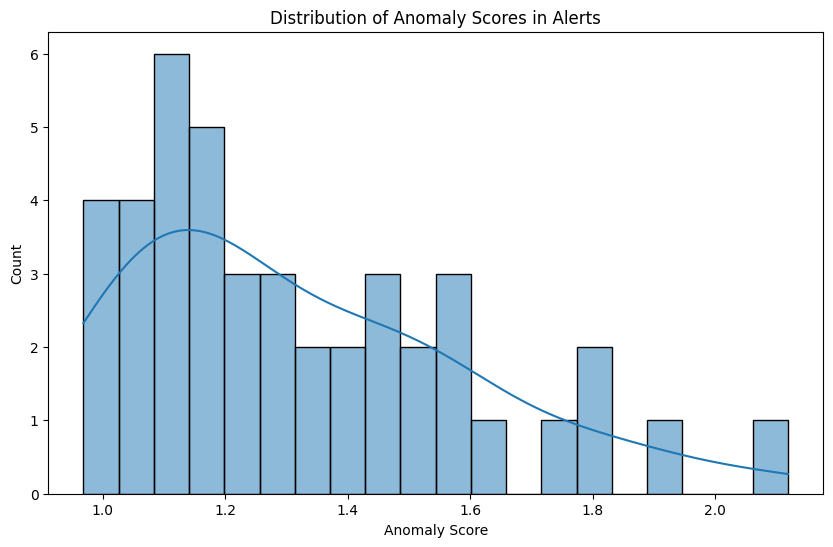

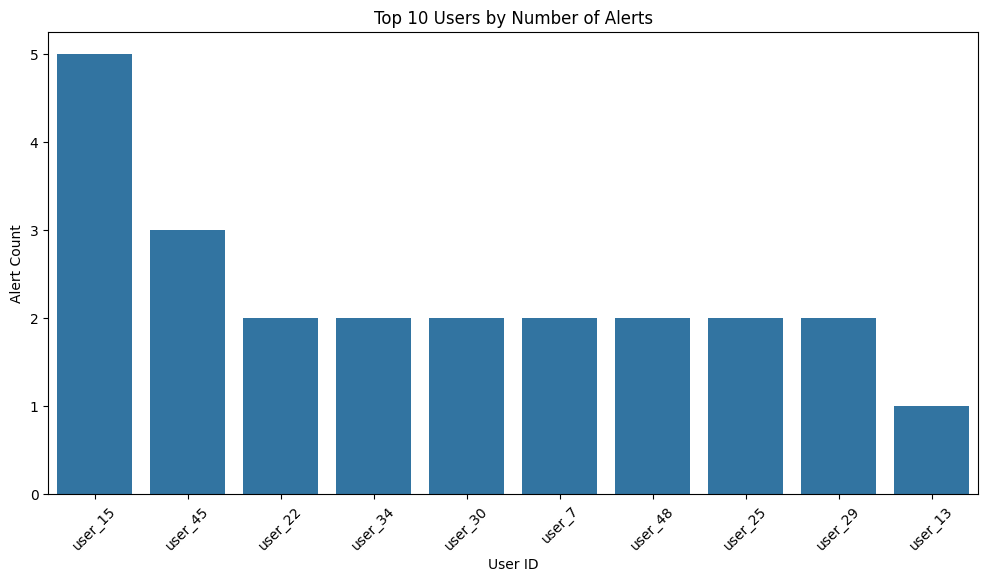

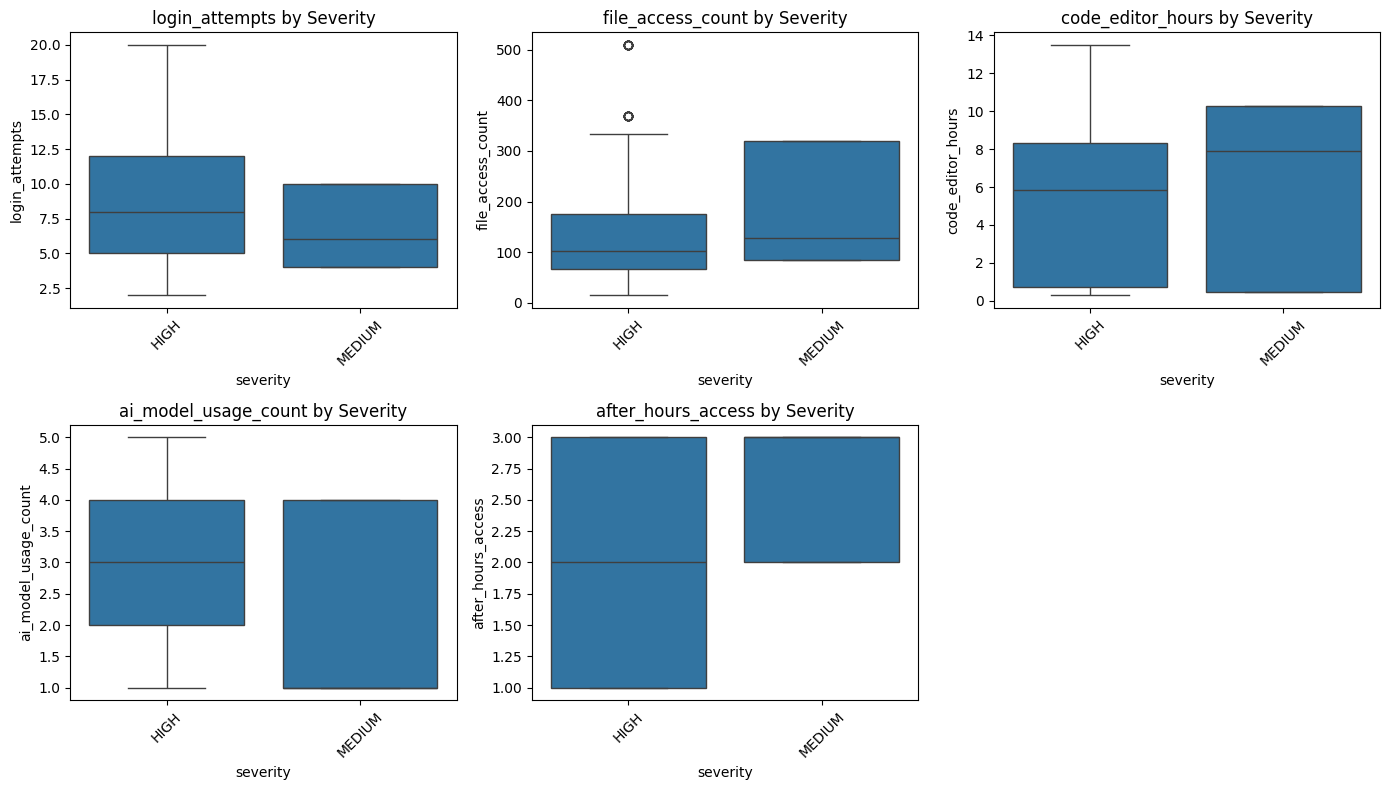